In [1]:
pip install torch-summary

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_env = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/train_PFAS_ENV.csv')
train_geo = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/train_PFAS_GEOSPATIAL.csv')
train_inorg = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/train_PFAS_INORGANICS_AND_OTHER.csv')
train_pharma = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/train_PFAS_PHARMA.csv')
train_vocs = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/train_PFAS_VOCs.csv')

In [5]:
# Merge train_env, train_geo, train_inorg, train_pharma, and train_vocs on NAWQA_ID

merged_train = train_env.merge(train_geo, on='NAWQA_ID', how='outer')
merged_train = merged_train.merge(train_inorg, on=['NAWQA_ID', 'DATE', 'TIME'], how='outer')
merged_train = merged_train.merge(train_pharma, on=['NAWQA_ID', 'DATE', 'TIME'], how='outer')
merged_train = merged_train.merge(train_vocs, on=['NAWQA_ID', 'DATE', 'TIME'], how='outer')

In [6]:
merged_train_X = merged_train.drop(columns=train_env.columns, inplace=False)
merged_train_y = merged_train[['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA']]

In [7]:
train_pharma.head()

,NAWQA_ID,DATE,TIME,THIA-RMK,THIA-VA,17DIM-RMK,17DIM-VA,10HYDR-RMK,10HYDR-VA,ABAC -RMK,...,WARF-RMK,WARF-VA,GABA-RMK,GABA-VA,GUAN-RMK,GUAN-VA,HEXA-RMK,HEXA-VA,RACTO-RMK,RACTO-VA
0,MIAMSUS1-01,8/21/2019,1200,<,11.0,<,140,<,8.3,<,...,<,6,<,160.0,NaN,NaN,<,110,<,20
1,MIAMSUS1-02,7/1/2019,1100,<,11.0,<,88,<,8.3,<,...,<,6,<,160.0,<,400.0,<,110,<,20
2,MIAMSUS1-05,7/10/2019,1100,<,11.0,<,88,<,8.3,<,...,<,6,<,160.0,<,400.0,<,110,<,20
3,MIAMSUS1-06,7/11/2019,1100,<,11.0,<,88,<,8.3,<,...,<,6,<,160.0,<,400.0,<,110,<,20
4,MIAMSUS1-07,7/15/2019,1100,<,11.0,<,88,<,8.3,<,...,<,6,<,160.0,<,400.0,<,110,<,20


In [8]:
merged_train.head()

,NAWQA_ID,DATE,TIME,4_2 FTS-RMK,4_2 FTS-VA,6_2 FTS-RMK,6_2 FTS-VA,8_2 FTS-RMK,8_2 FTS-VA,N-EtFOSAA-RMK,...,5MHEX-RMK,5MHEX-VA,BUTA-RMK,BUTA-VA,IACE-RMK,IACE-VA,NPENAL-RMK,NPENAL-VA,PACE-RMK,PACE-VA
0,MIAMSUS1-01,8/21/2019,1200,<,8.0,<,8.0,<,8.0,<,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MIAMSUS1-02,7/1/2019,1100,<,7.7,<,7.7,<,7.7,<,...,<,0.022,<,0.08,<,0.01,<,0.054,<,0.032
2,MIAMSUS1-05,7/10/2019,1100,<,8.0,<,8.0,<,8.0,<,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MIAMSUS1-06,7/11/2019,1100,<,8.0,<,8.0,<,8.0,<,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MIAMSUS1-07,7/15/2019,1100,<,8.0,<,8.0,<,8.0,<,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Check for numeric columns
numeric_cols = merged_train_X.select_dtypes(include=['number']).columns
print("Numeric columns:\n", numeric_cols)

# Check for categorical columns
categorical_cols = merged_train_X.select_dtypes(include=['object']).columns
print("\nCategorical columns:\n", categorical_cols)

Numeric columns:
 Index(['AGRI_12', 'NATU_12', 'URBA_12', 'WSWT', 'FIRE_TRAIN', 'CEMT', 'CHEM ',
       'CLEAN  ', 'CONS ', 'ELEC ',
       ...
       '1OCOL-VA', '26DNH-VA', '2EHEX-VA', '2MPA-VA', '4MPOL-VA', '5MHEX-VA',
       'BUTA-VA', 'IACE-VA', 'NPENAL-VA', 'PACE-VA'],
      dtype='object', length=240)

Categorical columns:
 Index(['N_LOAD', 'TURB-RMK', 'O2-RMK', 'BR-RMK', 'TDS-RMK', 'NH4-RMK',
       'NO3-RMK', 'ON-RMK', 'TN-RMK', 'OP-RMK',
       ...
       '1OCOL-RMK', '26DNH-RMK', '2EHEX-RMK', '2MPA-RMK', '4MPOL-RMK',
       '5MHEX-RMK', 'BUTA-RMK', 'IACE-RMK', 'NPENAL-RMK', 'PACE-RMK'],
      dtype='object', length=196)


### Exploratory Analysis and Data Preprocessing

In [10]:
# Summary Stats
merged_train_X[numeric_cols].describe()

,AGRI_12,NATU_12,URBA_12,WSWT,FIRE_TRAIN,CEMT,CHEM,CLEAN,CONS,ELEC,...,1OCOL-VA,26DNH-VA,2EHEX-VA,2MPA-VA,4MPOL-VA,5MHEX-VA,BUTA-VA,IACE-VA,NPENAL-VA,PACE-VA
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,...,1.550000e+02,155.000000,1.550000e+02,155.000000,1.550000e+02,155.000000,155.000000,1.550000e+02,155.000000,155.000000
mean,18.288177,29.027094,52.683251,8830.492611,113578.512315,69006.123153,14592.162562,36378.206897,64654.344828,22894.270936,...,1.800000e+00,0.031910,4.400000e+00,0.027639,2.000000e-01,0.021910,0.078677,1.000000e-02,0.053819,0.031910
std,26.142520,31.632708,38.751096,10286.154977,83418.463012,38094.589138,13083.295268,30571.366268,45181.515301,20954.515127,...,5.123580e-15,0.000417,1.247480e-14,0.001667,5.290654e-16,0.000417,0.008428,6.961386e-18,0.000833,0.000417
min,0.000000,0.000000,0.000000,137.000000,1466.000000,3834.000000,307.000000,775.000000,336.000000,315.000000,...,1.800000e+00,0.030000,4.400000e+00,0.020000,2.000000e-01,0.020000,0.012000,1.000000e-02,0.050000,0.030000
25%,0.000000,2.300000,7.700000,2240.500000,35470.000000,34764.000000,5044.000000,10676.000000,32840.000000,6459.500000,...,1.800000e+00,0.032000,4.400000e+00,0.028000,2.000000e-01,0.022000,0.080000,1.000000e-02,0.054000,0.032000
50%,4.100000,15.000000,57.700000,6036.000000,96954.000000,72799.000000,10578.000000,26983.000000,58017.000000,14940.000000,...,1.800000e+00,0.032000,4.400000e+00,0.028000,2.000000e-01,0.022000,0.080000,1.000000e-02,0.054000,0.032000
75%,30.250000,48.850000,91.350000,10644.500000,195962.500000,95263.000000,20444.000000,54394.500000,83138.500000,35029.500000,...,1.800000e+00,0.032000,4.400000e+00,0.028000,2.000000e-01,0.022000,0.080000,1.000000e-02,0.054000,0.032000
max,100.000000,100.000000,100.000000,77274.000000,289521.000000,156145.000000,68966.000000,137575.000000,241631.000000,87961.000000,...,1.800000e+00,0.032000,4.400000e+00,0.028000,2.000000e-01,0.022000,0.080000,1.000000e-02,0.054000,0.032000


In [11]:
# Nulls
total_nans = merged_train_X[numeric_cols].isnull().sum().sum()
total_elements = merged_train_X[numeric_cols].size  # Total number of elements in the DataFrame
percentage_nans = (total_nans / total_elements) * 100
print(f"Total NaNs: {total_nans}")
print(f"Percentage of DataFrame that is NaNs: {percentage_nans:.2f}%")


merged_train_X[numeric_cols].isnull().sum()
dropped_columns = [col for col in numeric_cols if merged_train_X[col].isnull().all()]
merged_train_X = merged_train_X.drop(columns=dropped_columns)
print(f"Dropped {dropped_columns} columns that were completely null.")
numeric_cols = [col for col in numeric_cols if col not in dropped_columns]

Total NaNs: 7669
Percentage of DataFrame that is NaNs: 15.74%
Dropped ['PH-RMK', 'SC-RMK', 'CA-RMK', 'MG-RMK', 'CL-RMK', 'SO4-RMK', '3H_SSCL-RMK'] columns that were completely null.


In [12]:
merged_train_X.shape

(203, 429)

In [13]:
pfas_data_imputed = merged_train_X[numeric_cols].interpolate(method='linear', limit_direction='both')
# imputer = SimpleImputer(strategy='median')
# imputer = SimpleImputer(strategy='most_frequent')
# pfas_data_imputed = imputer.fit_transform(merged_train_X[numeric_cols])
scaler = StandardScaler()
pfas_scaled = scaler.fit_transform(pfas_data_imputed)
pfas_scaled_y = merged_train_y
# pfas_scaled_y = scaler.fit_transform(merged_train_y)

In [14]:
pfas_scaled_df = pd.DataFrame(pfas_scaled, columns=numeric_cols)
pfas_scaled_y_df = pd.DataFrame(pfas_scaled_y, columns=['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA'])

In [15]:
print(list(pfas_scaled_df.columns))

['AGRI_12', 'NATU_12', 'URBA_12', 'WSWT', 'FIRE_TRAIN', 'CEMT', 'CHEM ', 'CLEAN  ', 'CONS ', 'ELEC ', 'FURN_CARP', 'GLASS', 'INDU_GAS', 'LANDF ', 'METAL  ', 'MACH  ', 'MINE ', 'OILGAS', 'PAINT  ', 'NATDEF   ', 'PAPER  ', 'PETR  ', 'PLAS  ', 'TEXTILE', 'AIRNG', 'ARMNG', 'FIRE_ST', 'FRS', 'SUPER ', 'OILREF', 'AIRP', 'TURB-VA', 'O2-VA', 'PH-VA', 'SC-VA', 'CA-VA', 'MG-VA', 'BR-VA', 'CL-VA', 'SO4-VA', 'TDS-VA', 'NH4-VA', 'NO3-VA', 'ON-VA', 'TN-VA', 'OP-VA', 'DOC-VA', 'B-VA', 'CR-VA', 'FE-VA', 'MN-VA', 'U-VA', 'V-VA', '3H-VA', '3H_CSU-VA', '3H_SSCL-VA', 'THIA-VA', '17DIM-VA', '10HYDR-VA', 'ABAC -VA', 'ACET-VA', 'ACYC-VA', 'ALBU-VA', 'ALPR-VA', 'AMIT-VA', 'AMPH-VA', 'ANTI-VA', 'ATEN-VA', 'BENZ-VA', 'BETA-VA', 'BUPR-VA', 'CARB-VA', 'CARI-VA', 'CHLO-VA', 'CIME-VA', 'CITA-VA', 'CLON-VA', 'CODE-VA', 'DEHY-VA', 'DESM-VA', 'DESV-VA', 'DEXT-VA', 'DIAZ-VA', 'DILT-VA', 'DIPH-VA', 'DULO-VA', 'ERYT-VA', 'EZET-VA', 'FADR-VA', 'FAMO-VA', 'FENO-VA', 'FEXO-VA', 'FLUC-VA', 'FLUO-VA', 'FLUT-VA', 'FLUV-VA', 'G

In [16]:
# Remove little to no variance
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
reduced_X = selector.fit_transform(pfas_scaled)
selected_features = pfas_scaled_df.columns[selector.get_support()]
pfas_scaled_df = pd.DataFrame(reduced_X, columns=selected_features)
numeric_cols = selected_features.tolist()
print(f"Dropped {len(pfas_scaled_df.columns) - len(selected_features)} features with low variance.")

Dropped 0 features with low variance.


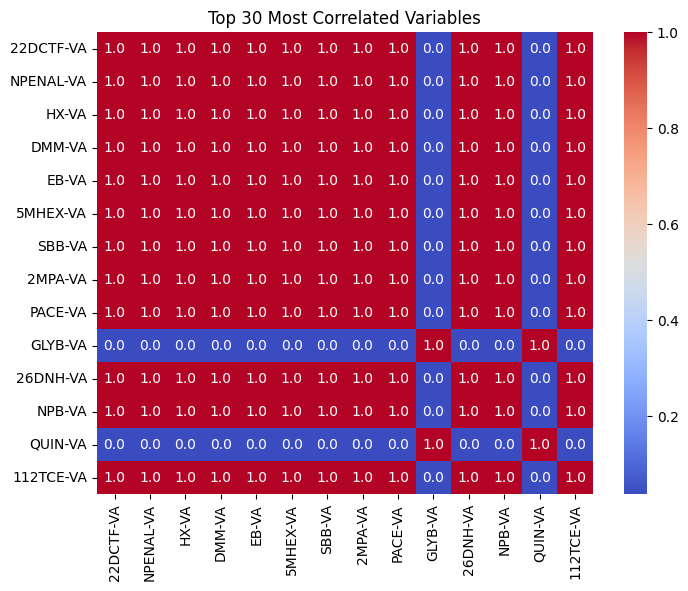

Dropped 40 highly correlated features.


In [17]:
# Remove highly-correlated features
threshold = 0.95
correlation_matrix = pfas_scaled_df.corr().abs()

correlation_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
correlation_pairs = correlation_pairs[correlation_pairs < 1]
top_n_pairs = correlation_pairs.head(30)
top_n_vars = list(set([idx[0] for idx in top_n_pairs.index] + [idx[1] for idx in top_n_pairs.index]))
top_n_corr_matrix = correlation_matrix.loc[top_n_vars, top_n_vars]

plt.figure(figsize=(8, 6))
sns.heatmap(top_n_corr_matrix, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Top 30 Most Correlated Variables")
plt.show()

upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
pfas_scaled_df = pfas_scaled_df.drop(columns=to_drop)
numeric_cols = [col for col in numeric_cols if col not in to_drop]
print(f"Dropped {len(to_drop)} highly correlated features.")

In [19]:
len(pfas_scaled_df)

203

### Neural Network

In [42]:
# Neural Network for Regression

class MultiOutputRegressionNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiOutputRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        # self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        # self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, output_dim)  # Output layer with output_dim neurons

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc3(x)  # Outputs a vector of size output_dim
        return x

# Ridge Regressor
class RidgeRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RidgeRegression, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

def train_model(model, X_train, Y_train, X_val, Y_val, epochs):
    # Store loss values
    train_loss_values = []
    val_loss_values = []

    # Training loop
    for epoch in range(epochs + 1):
        # Train
        model.train()
        optimizer.zero_grad()
        train_predictions = model(X_train)
        train_loss = criterion(train_predictions, Y_train)
        train_loss.backward()
        optimizer.step()
        train_loss_values.append(train_loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val)
            val_loss = criterion(val_predictions, Y_val)
            val_loss_values.append(val_loss.item())

        # Print loss at intervals
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Plot the loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs + 1), train_loss_values, label='Training Loss')
    plt.plot(range(epochs + 1), val_loss_values, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(VariationalAutoencoder, self).__init__()
        # Encoder: Maps input to latent space parameters (mean and log variance)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_dim * 2)  # Output both mean and log variance
        )

        # Decoder: Maps latent space back to reconstructed input
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        # Encode: Output mean and log variance
        encoded = self.encoder(x)
        mu, log_var = encoded.chunk(2, dim=-1)  # Split the output into mean and log variance

        # Reparameterization trick: Sample latent vector z
        std = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation
        epsilon = torch.randn_like(std)  # Random noise
        z = mu + epsilon * std  # Reparameterization

        # Decode: Reconstruct input from latent vector
        decoded = self.decoder(z)

        return z, decoded, mu, log_var  # Return latent vector, reconstruction, mean, and log variance

def vae_loss(reconstructed, original, mu, log_var):
    reconstruction_loss = nn.MSELoss()(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

def encoder_train_model(model, X_train, Y_train, X_val, Y_val, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        optimizer.zero_grad()
        _, decoded_train = model(X_train)  # Only use decoded output for reconstruction loss
        train_loss = criterion(decoded_train, X_train)
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        # Validation Phase
        model.eval()
        with torch.no_grad():
            _, decoded_val = model(X_val)  # Only use decoded output
            val_loss = criterion(decoded_val, X_val)
            val_losses.append(val_loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Plot Training and Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return model

def vae_train_model(model,  X_train, Y_train, X_val, Y_val, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        optimizer.zero_grad()

        z_train, reconstructed_train, mu_train, log_var_train = model(X_train)
        train_loss = vae_loss(reconstructed_train, X_train, mu_train, log_var_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        # Validation Phase
        model.eval()
        with torch.no_grad():
            z_val, reconstructed_val, mu_val, log_var_val = model(X_val)
            val_loss = vae_loss(reconstructed_val, X_val, mu_val, log_var_val)
            val_losses.append(val_loss.item())

        # Print loss for every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Plot Training and Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return model

In [65]:
print(list(pfas_scaled_df.columns))

['AGRI_12', 'NATU_12', 'URBA_12', 'WSWT', 'FIRE_TRAIN', 'CEMT', 'CHEM ', 'CLEAN  ', 'CONS ', 'ELEC ', 'FURN_CARP', 'GLASS', 'INDU_GAS', 'LANDF ', 'METAL  ', 'MACH  ', 'MINE ', 'OILGAS', 'PAINT  ', 'NATDEF   ', 'PAPER  ', 'PETR  ', 'PLAS  ', 'TEXTILE', 'AIRNG', 'ARMNG', 'FIRE_ST', 'FRS', 'SUPER ', 'OILREF', 'AIRP', 'TURB-VA', 'O2-VA', 'PH-VA', 'SC-VA', 'CA-VA', 'MG-VA', 'BR-VA', 'CL-VA', 'SO4-VA', 'NH4-VA', 'NO3-VA', 'ON-VA', 'OP-VA', 'DOC-VA', 'B-VA', 'CR-VA', 'FE-VA', 'MN-VA', 'U-VA', 'V-VA', '3H-VA', '3H_CSU-VA', '3H_SSCL-VA', 'THIA-VA', '17DIM-VA', '10HYDR-VA', 'ABAC -VA', 'ACET-VA', 'ACYC-VA', 'AMIT-VA', 'ATEN-VA', 'BETA-VA', 'CARB-VA', 'CARI-VA', 'CHLO-VA', 'CIME-VA', 'CITA-VA', 'DEHY-VA', 'DESM-VA', 'DEXT-VA', 'DIAZ-VA', 'DILT-VA', 'DULO-VA', 'ERYT-VA', 'FADR-VA', 'FAMO-VA', 'FENO-VA', 'FLUT-VA', 'GLIP-VA', 'HYDRD-VA', 'HYDRC-VA', 'IMIN-VA', 'KETO-VA', 'LOPE-VA', 'META-VA', 'METF-VA', 'METHD-VA', 'METHC-VA', 'METO-VA', 'NORF-VA', 'NORS-VA', 'NORV-VA', 'OSEL-VA', 'PHENA-VA', 'PHEN

### Training

In [43]:
output_dim = merged_train_y.shape[1]
input_dim = pfas_scaled_df.shape[1]
print('Input Dimension:', input_dim, 'Output Dimension', output_dim, 'Total Samples', pfas_scaled_df.shape[0])

# Validation
X_train, X_val, Y_train, Y_val = train_test_split(pfas_scaled_df.to_numpy(), merged_train_y.to_numpy(), test_size=0.3, random_state=42)

# Convert to tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
Y_train, Y_val = torch.tensor(Y_train, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32)


Input Dimension: 133 Output Dimension 4 Total Samples 203


#### Neural Network

Epoch 0, Train Loss: 4085.8428, Val Loss: 141.6042
Epoch 50, Train Loss: 3731.5999, Val Loss: 105.3795
Epoch 100, Train Loss: 2335.0010, Val Loss: 788.1641
Epoch 150, Train Loss: 714.7810, Val Loss: 1829.9755
Epoch 200, Train Loss: 96.1717, Val Loss: 1614.7911
Epoch 250, Train Loss: 15.8937, Val Loss: 1705.9135
Epoch 300, Train Loss: 8.9144, Val Loss: 1671.7728


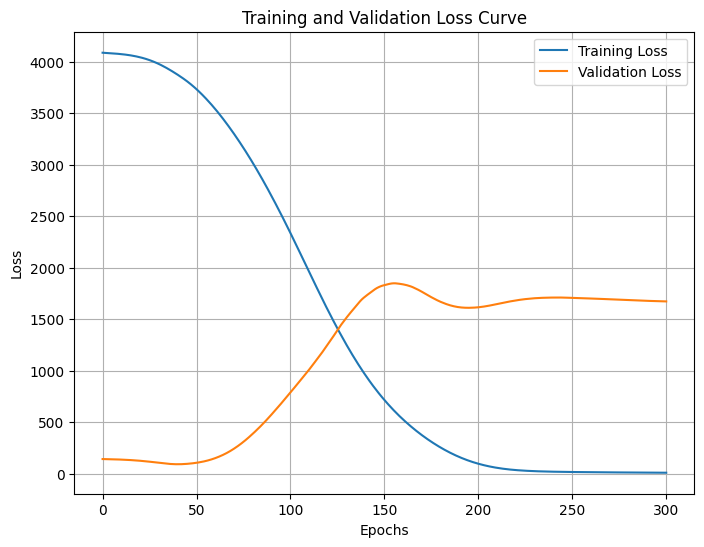

In [44]:
model_nn = MultiOutputRegressionNN(input_dim, output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)

model_nn = train_model(model_nn, X_train, Y_train, X_val, Y_val, 300)

In [45]:
summary(model_nn)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            17,152
├─Linear: 1-2                            8,256
├─Linear: 1-3                            260
Total params: 25,668
Trainable params: 25,668
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            17,152
├─Linear: 1-2                            8,256
├─Linear: 1-3                            260
Total params: 25,668
Trainable params: 25,668
Non-trainable params: 0

#### Ridge Regressor

Epoch 0, Train Loss: 4085.0044, Val Loss: 139.1620
Epoch 50, Train Loss: 3866.3120, Val Loss: 189.8717
Epoch 100, Train Loss: 3705.9688, Val Loss: 260.6517
Epoch 150, Train Loss: 3571.0679, Val Loss: 329.6105
Epoch 200, Train Loss: 3451.5479, Val Loss: 397.8011
Epoch 250, Train Loss: 3342.9287, Val Loss: 466.7611
Epoch 300, Train Loss: 3242.6965, Val Loss: 536.8460


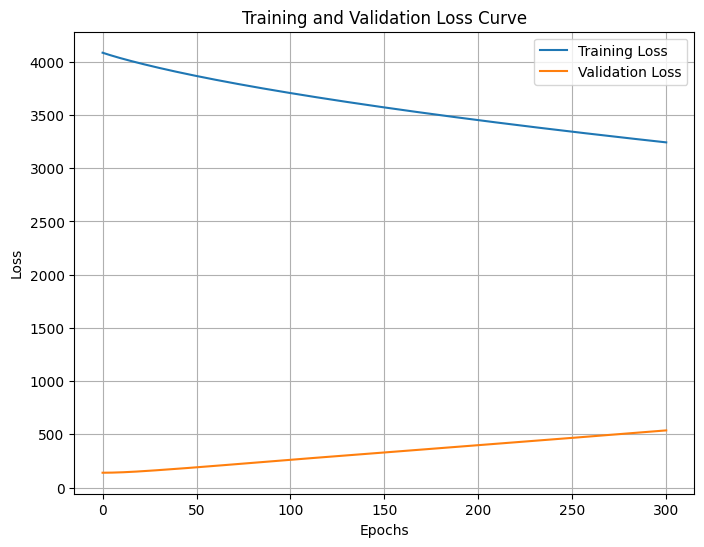

In [46]:
model_ridge = RidgeRegression(input_dim, output_dim)

optimizer = torch.optim.Adam(model_ridge.parameters(), lr=0.01)

model_ridge = train_model(model_ridge, X_train, Y_train, X_val, Y_val, 300)

#### Autoencoder

Epoch 0, Train Loss: 1.0053, Val Loss: 1.0278
Epoch 50, Train Loss: 0.5015, Val Loss: 0.7108
Epoch 100, Train Loss: 0.2606, Val Loss: 0.6052
Epoch 150, Train Loss: 0.1591, Val Loss: 0.5796


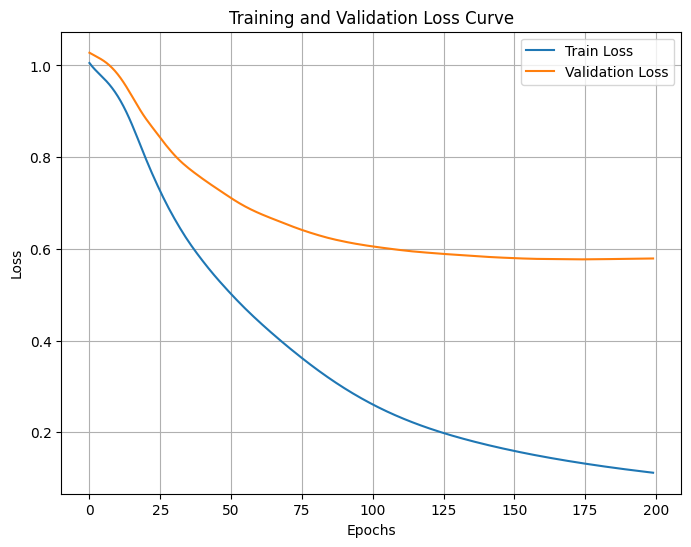

In [47]:
# Dimensionality Reduction
encoded_dim = 10
autoencoder = Autoencoder(input_dim, encoded_dim)
model_encoder = Autoencoder(input_dim, encoded_dim)

optimizer = torch.optim.Adam(model_encoder.parameters(), lr=0.001)
model_encoder = encoder_train_model(model_encoder, X_train, Y_train, X_val, Y_val, 200)

model_encoder.eval()
with torch.no_grad():
    ae_encoding_train, ae_decoding_train = model_encoder(X_train)
    ae_encoding_val, ae_decoding_val = model_encoder(X_val)

#### Variational Autoencoder

Epoch 0/200, Train Loss: 58.2737, Val Loss: 21.8819
Epoch 10/200, Train Loss: 9.2401, Val Loss: 9.8737
Epoch 20/200, Train Loss: 4.2395, Val Loss: 8.1720
Epoch 30/200, Train Loss: 2.5101, Val Loss: 7.4703
Epoch 40/200, Train Loss: 1.7550, Val Loss: 7.0130
Epoch 50/200, Train Loss: 1.4368, Val Loss: 6.7948
Epoch 60/200, Train Loss: 1.2811, Val Loss: 6.6574
Epoch 70/200, Train Loss: 1.1931, Val Loss: 6.5753
Epoch 80/200, Train Loss: 1.1402, Val Loss: 6.5139
Epoch 90/200, Train Loss: 1.1045, Val Loss: 6.4744
Epoch 100/200, Train Loss: 1.0793, Val Loss: 6.4388
Epoch 110/200, Train Loss: 1.0610, Val Loss: 6.4094
Epoch 120/200, Train Loss: 1.0500, Val Loss: 6.3848
Epoch 130/200, Train Loss: 1.0369, Val Loss: 6.3731
Epoch 140/200, Train Loss: 1.0324, Val Loss: 6.3569
Epoch 150/200, Train Loss: 1.0254, Val Loss: 6.3477
Epoch 160/200, Train Loss: 1.0204, Val Loss: 6.3414
Epoch 170/200, Train Loss: 1.0151, Val Loss: 6.3292
Epoch 180/200, Train Loss: 1.0126, Val Loss: 6.3247
Epoch 190/200, Train 

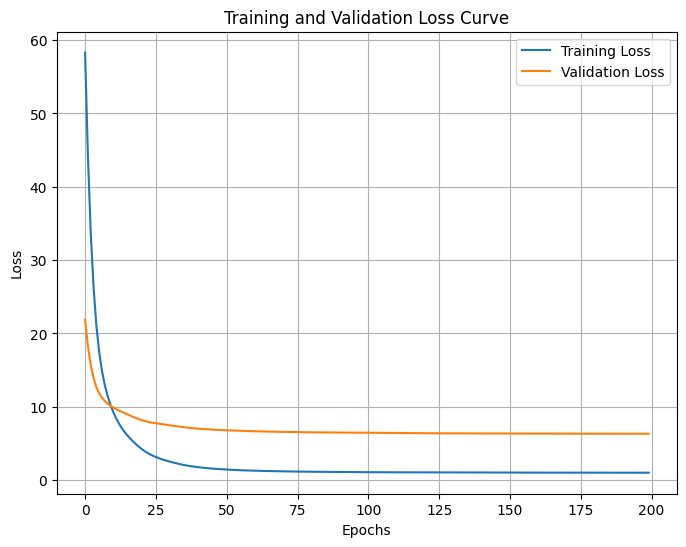

In [48]:
# Dimensionality Reduction
encoded_dim = 10
autoencoder = VariationalAutoencoder(input_dim, encoded_dim)
model_vaencoder = VariationalAutoencoder(input_dim, encoded_dim)

optimizer = torch.optim.Adam(model_vaencoder.parameters(), lr=0.001)
model_vaencoder = vae_train_model(model_vaencoder, X_train, Y_train, X_val, Y_val, 200)

model_vaencoder.eval()
with torch.no_grad():
    vae_encoding_train, vae_decoding_train, _, _ = model_vaencoder(X_train)
    vae_encoding_val, vae_decoding_val, _, _ = model_vaencoder(X_val)

### Autoencoder + Neural Network

Epoch 0, Train Loss: 4084.4978, Val Loss: 140.2221
Epoch 50, Train Loss: 3869.2002, Val Loss: 95.1087
Epoch 100, Train Loss: 3211.6694, Val Loss: 212.1314
Epoch 150, Train Loss: 2313.7898, Val Loss: 411.0735
Epoch 200, Train Loss: 1492.3977, Val Loss: 578.1429
Epoch 250, Train Loss: 861.2276, Val Loss: 713.5062
Epoch 300, Train Loss: 492.8853, Val Loss: 686.8817


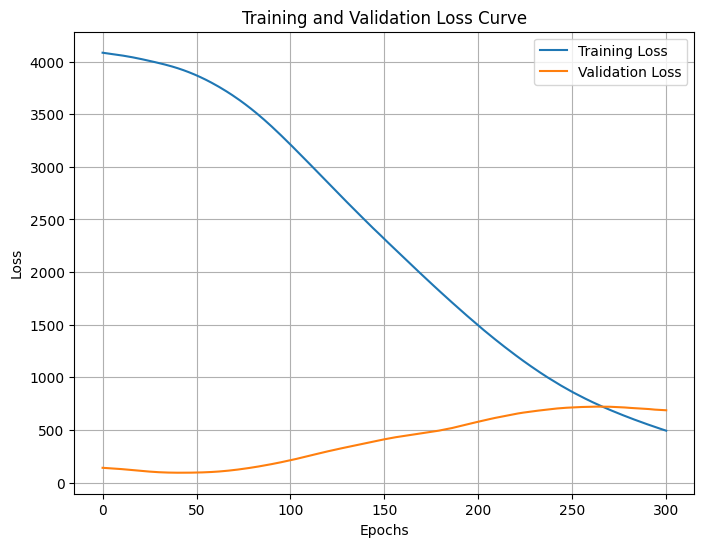

In [49]:
model_ae_nn = MultiOutputRegressionNN(ae_encoding_train.shape[1], output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_ae_nn.parameters(), lr=0.001)

model_ae_nn = train_model(model_ae_nn, ae_encoding_train, Y_train, ae_encoding_val, Y_val, 300)

Epoch 0, Train Loss: 4085.0366, Val Loss: 135.9907
Epoch 50, Train Loss: 1954.0123, Val Loss: 654.9667
Epoch 100, Train Loss: 46.3168, Val Loss: 2363.4731
Epoch 150, Train Loss: 28.3365, Val Loss: 2199.5752
Epoch 200, Train Loss: 20.9728, Val Loss: 2228.4910
Epoch 250, Train Loss: 15.5529, Val Loss: 2439.6768
Epoch 300, Train Loss: 11.1236, Val Loss: 2526.4761


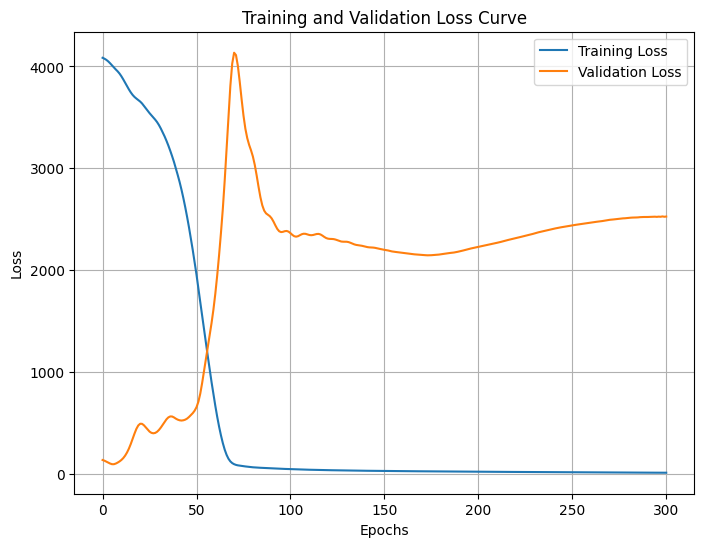

In [50]:
model_vae_nn = MultiOutputRegressionNN(vae_encoding_train.shape[1], output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_vae_nn.parameters(), lr=0.01)

model_ae_ridge = train_model(model_vae_nn, vae_encoding_train, Y_train, vae_encoding_val, Y_val, 300)

#### PCA + Neural Network

Epoch 0, Train Loss: 4087.5164, Val Loss: 131.1023
Epoch 50, Train Loss: 2529.1758, Val Loss: 703.5285
Epoch 100, Train Loss: 32.4739, Val Loss: 792.3431
Epoch 150, Train Loss: 14.3542, Val Loss: 688.8287
Epoch 200, Train Loss: 7.1305, Val Loss: 644.7958
Epoch 250, Train Loss: 4.9249, Val Loss: 657.8578
Epoch 300, Train Loss: 3.5782, Val Loss: 678.2173


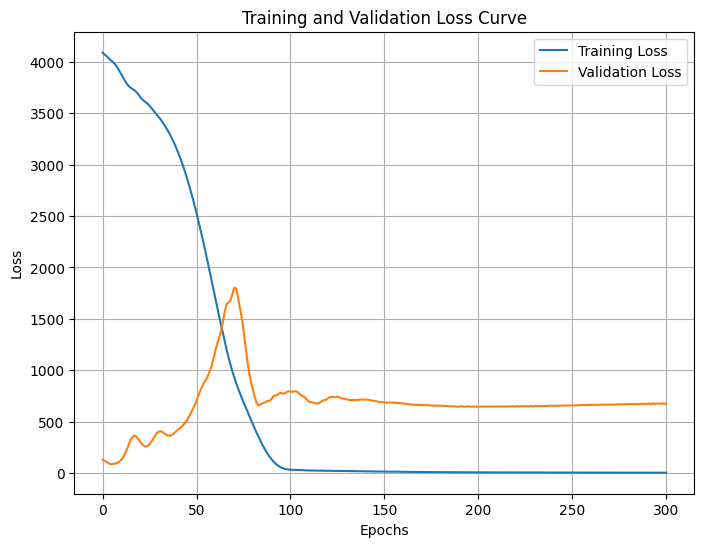

In [51]:
pca = PCA(n_components=10)
pca_encoding_train = pca.fit_transform(X_train)
pca_encoding_val = pca.transform(X_val)

pca_encoding_train, pca_encoding_val = torch.tensor(pca_encoding_train, dtype=torch.float32), torch.tensor(pca_encoding_val, dtype=torch.float32)

model_pca_nn = MultiOutputRegressionNN(pca_encoding_train.shape[1], output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_pca_nn.parameters(), lr=0.01)

model_pca_nn = train_model(model_pca_nn, pca_encoding_train, Y_train, pca_encoding_val, Y_val, 300)

#### Autoencoder + Ridge Regression

Epoch 0, Train Loss: 4103.8706, Val Loss: 143.0202
Epoch 50, Train Loss: 4012.9463, Val Loss: 142.0697
Epoch 100, Train Loss: 3953.9490, Val Loss: 143.7256
Epoch 150, Train Loss: 3908.5383, Val Loss: 143.8416
Epoch 200, Train Loss: 3871.0669, Val Loss: 142.8336
Epoch 250, Train Loss: 3839.5769, Val Loss: 142.0040
Epoch 300, Train Loss: 3812.9868, Val Loss: 141.9408


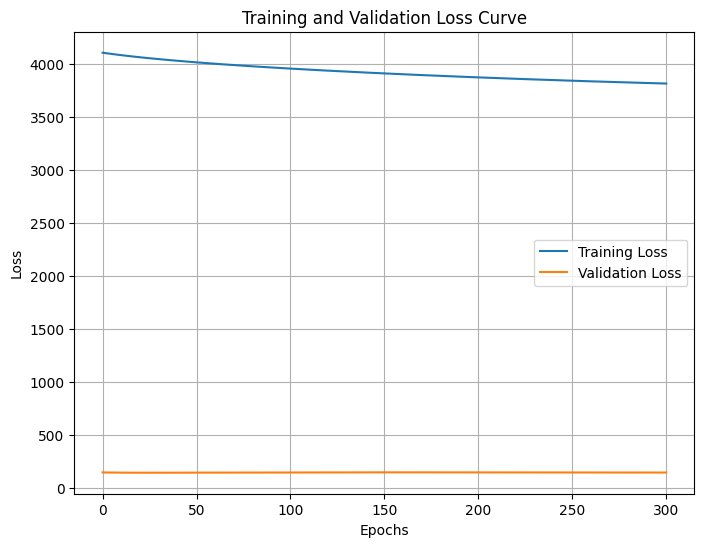

In [52]:
model_ae_ridge = RidgeRegression(ae_encoding_train.shape[1], output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_ae_ridge.parameters(), lr=0.01)

model_ae_ridge = train_model(model_ae_ridge, ae_encoding_train, Y_train, ae_encoding_val, Y_val, 300)

#### Variational Autoencoder + Ridge

Epoch 0, Train Loss: 4081.6245, Val Loss: 139.7680
Epoch 50, Train Loss: 4051.6421, Val Loss: 135.2880
Epoch 100, Train Loss: 4026.1130, Val Loss: 132.4053
Epoch 150, Train Loss: 4003.5071, Val Loss: 130.7536
Epoch 200, Train Loss: 3983.1196, Val Loss: 129.9165
Epoch 250, Train Loss: 3964.6135, Val Loss: 129.7230
Epoch 300, Train Loss: 3947.7812, Val Loss: 130.1553


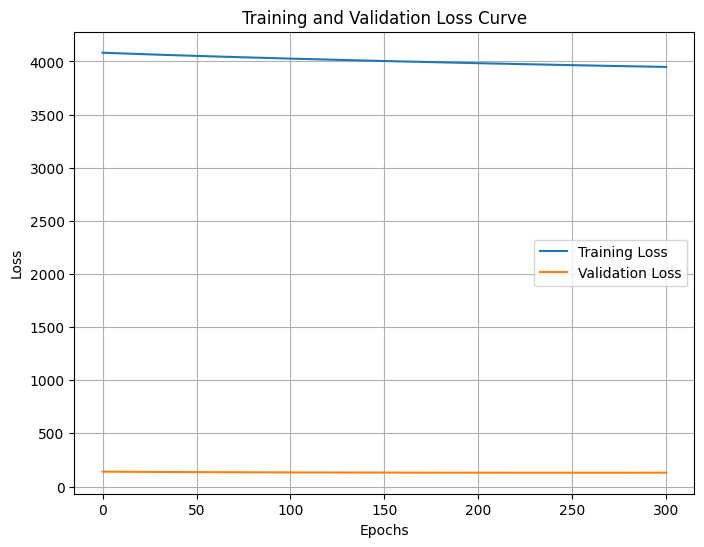

In [53]:
model_vae_ridge = RidgeRegression(vae_encoding_train.shape[1], output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_vae_ridge.parameters(), lr=0.01)

model_ae_ridge = train_model(model_vae_ridge, vae_encoding_train, Y_train, vae_encoding_val, Y_val, 300)

#### PCA + Ridge Regression

Epoch 0, Train Loss: 4083.5391, Val Loss: 141.1279
Epoch 50, Train Loss: 3915.0774, Val Loss: 94.2959
Epoch 100, Train Loss: 3604.7668, Val Loss: 237.8820
Epoch 150, Train Loss: 3301.8118, Val Loss: 373.5345
Epoch 200, Train Loss: 2882.8723, Val Loss: 500.7491
Epoch 250, Train Loss: 2335.3926, Val Loss: 758.4699
Epoch 300, Train Loss: 1738.3582, Val Loss: 1102.7217


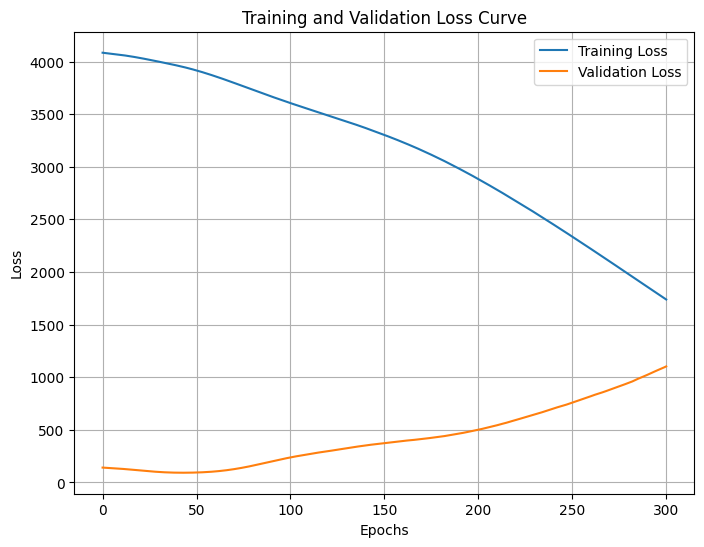

In [54]:
pca = PCA(n_components=10)
pca_encoding_train = pca.fit_transform(X_train)
pca_encoding_val = pca.transform(X_val)

pca_encoding_train, pca_encoding_val = torch.tensor(pca_encoding_train, dtype=torch.float32), torch.tensor(pca_encoding_val, dtype=torch.float32)

model_pca_ridge = MultiOutputRegressionNN(pca_encoding_train.shape[1], output_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_pca_ridge.parameters(), lr=0.001)

model_pca_ridge = train_model(model_pca_ridge, pca_encoding_train, Y_train, pca_encoding_val, Y_val, 300)

### Test

In [55]:
# Test data
test_env = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/test_PFAS_ENV.csv')
test_geo = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/test_PFAS_GEOSPATIAL.csv')
test_inorg = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/test_PFAS_INORGANICS_AND_OTHER.csv')
test_pharma = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/test_PFAS_PHARMA.csv')
test_vocs = pd.read_csv('/content/drive/MyDrive/PFAS/data/traintest_data/test_PFAS_VOCs.csv')

merged_test = test_env.merge(test_geo, on='NAWQA_ID', how='outer')
merged_test = merged_test.merge(test_inorg, on=['NAWQA_ID', 'DATE', 'TIME'], how='outer')
merged_test = merged_test.merge(test_pharma, on=['NAWQA_ID', 'DATE', 'TIME'], how='outer')
merged_test = merged_test.merge(test_vocs, on=['NAWQA_ID', 'DATE', 'TIME'], how='outer')

# Cannot have null ground truth values
merged_test = merged_test.dropna(subset=['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA'])
merged_test_X = merged_test.drop(columns=['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA'], inplace=False)
merged_test_y = merged_test[['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA']]

In [56]:
# Nulls
merged_test_X[numeric_cols].isnull().sum()
dropped_columns = [col for col in numeric_cols if merged_train_X[col].isnull().all()]
merged_test_X = merged_test_X.drop(columns=dropped_columns)
print(f"Dropped {dropped_columns} columns that were completely null.")
numeric_cols = [col for col in numeric_cols if col not in dropped_columns]

imputer = SimpleImputer(strategy='median')
pfas_data_imputed_test = imputer.fit_transform(merged_test_X[numeric_cols])
scaler = StandardScaler()
pfas_scaled_test = scaler.fit_transform(pfas_data_imputed_test)
pfas_scaled_test_y = scaler.fit_transform(merged_test_y)

pfas_scaled_test_df = pd.DataFrame(pfas_scaled_test, columns=numeric_cols)
pfas_scaled_test_y_df = pd.DataFrame(pfas_scaled_test_y, columns=['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA'])

pfas_scaled_test_df = pfas_scaled_test_df[pfas_scaled_df.columns]

Dropped [] columns that were completely null.


### Metrics

In [57]:
def calc_mse(predictions, ground_truth):
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mse = np.mean((predictions - ground_truth) ** 2)
    return mse

def calc_rmse(predictions, ground_truth):
    mse = calc_mse(predictions, ground_truth)
    rmse = np.sqrt(mse)
    return rmse

def calc_r_squared(predictions, ground_truth):
    residuals = ground_truth - predictions
    mean_ground_truth = np.mean(ground_truth)
    ssr = np.sum(residuals ** 2)
    sst = np.sum((ground_truth - mean_ground_truth) ** 2)

    # R² calculation
    r_squared = 1 - (ssr / sst)
    return r_squared

#### Neural Network

In [58]:
input_tensor = torch.tensor(pfas_scaled_test, dtype=torch.float32)

model_nn.eval()
with torch.no_grad():
    prediction = model_nn(input_tensor)

print("MSE:", calc_mse(prediction, merged_test_y))
print("RMSE:", calc_rmse(prediction, merged_test_y))
print("R-Sqaured:", calc_r_squared(prediction.numpy().copy(), merged_test_y))

MSE: 1111.5721889152146
RMSE: 33.340248783043215
R-Sqaured: PFOS-VA       0.152731
PFBA-VA      -0.886617
PFHxS-VA     -0.842885
PFOA-VA    -512.413297
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


#### Ridge Regressor

In [59]:
input_tensor = torch.tensor(pfas_scaled_test, dtype=torch.float32)

model_ridge.eval()
with torch.no_grad():
    prediction = model_ridge(input_tensor)

print("MSE:", calc_mse(prediction, merged_test_y))
print("RMSE:", calc_rmse(prediction, merged_test_y))
print("R-Sqaured:", calc_r_squared(prediction.numpy().copy(), merged_test_y))

MSE: 303.6213454314598
RMSE: 17.424733726271395
R-Sqaured: PFOS-VA     -0.057488
PFBA-VA    -20.606899
PFHxS-VA    -5.521001
PFOA-VA    -88.011322
dtype: float64


#### Autoencoder + Neural Network

In [60]:
input_tensor = torch.tensor(pfas_scaled_test, dtype=torch.float32)

model_encoder.eval()
with torch.no_grad():
    encoding_input, decoding_input = model_encoder(input_tensor)

print(f"Reconstruction Loss (MSE): {mean_squared_error(pfas_scaled_test, decoding_input):.4f}")

model_ae_nn.eval()
with torch.no_grad():
    prediction = model_ae_nn(encoding_input)

print("MSE:", calc_mse(prediction, merged_test_y))
print("RMSE:", calc_rmse(prediction, merged_test_y))
print("R-Sqaured:", calc_r_squared(prediction.numpy().copy(), merged_test_y))

Reconstruction Loss (MSE): 0.5085
MSE: 1363.367642127701
RMSE: 36.923808608101375
R-Sqaured: PFOS-VA       0.091951
PFBA-VA      -1.144312
PFHxS-VA     -0.060847
PFOA-VA    -635.286630
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


#### Autoencoder + Ridge Regression

In [61]:
input_tensor = torch.tensor(pfas_scaled_test, dtype=torch.float32)

model_encoder.eval()
with torch.no_grad():
    encoding_input, decoding_input = model_encoder(input_tensor)

print(f"Reconstruction Loss (MSE): {mean_squared_error(pfas_scaled_test, decoding_input):.4f}")

model_ridge.eval()
with torch.no_grad():
    prediction = model_ae_ridge(encoding_input)

print("MSE:", calc_mse(prediction, merged_test_y))
print("RMSE:", calc_rmse(prediction, merged_test_y))
print("R-Sqaured:", calc_r_squared(prediction.numpy().copy(), merged_test_y))

Reconstruction Loss (MSE): 0.5085
MSE: 170.37096825688735
RMSE: 13.052623041246818
R-Sqaured: PFOS-VA     -0.352196
PFBA-VA    -10.344360
PFHxS-VA    -1.291649
PFOA-VA    -30.439636
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


#### Variational Autoencoder + Neural Network

In [62]:
input_tensor = torch.tensor(pfas_scaled_test, dtype=torch.float32)

model_vaencoder.eval()
with torch.no_grad():
    encoding_input, decoding_input, _, _ = model_vaencoder(input_tensor)

print(f"Reconstruction Loss (MSE): {mean_squared_error(pfas_scaled_test, decoding_input):.4f}")

model_vae_nn.eval()
with torch.no_grad():
    prediction = model_vae_nn(encoding_input)

print("MSE:", calc_mse(prediction, merged_test_y))
print("RMSE:", calc_rmse(prediction, merged_test_y))
print("R-Sqaured:", calc_r_squared(prediction.numpy().copy(), merged_test_y))

Reconstruction Loss (MSE): 0.9248
MSE: 3476.006806811709
RMSE: 58.95766961822447
R-Sqaured: PFOS-VA       -0.018427
PFBA-VA       -0.448062
PFHxS-VA      -0.475687
PFOA-VA    -1664.302829
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


#### Variational Autoencoder + Ridge Regression

In [63]:
input_tensor = torch.tensor(pfas_scaled_test, dtype=torch.float32)

model_vaencoder.eval()
with torch.no_grad():
    encoding_input, decoding_input, _ , _ = model_vaencoder(input_tensor)

print(f"Reconstruction Loss (MSE): {mean_squared_error(pfas_scaled_test, decoding_input):.4f}")

model_vae_ridge.eval()
with torch.no_grad():
    prediction = model_vae_ridge(encoding_input)

print("MSE:", calc_mse(prediction, merged_test_y))
print("RMSE:", calc_rmse(prediction, merged_test_y))
print("R-Sqaured:", calc_r_squared(prediction.numpy().copy(), merged_test_y))

Reconstruction Loss (MSE): 0.9237
MSE: 95.49853811345854
RMSE: 9.772335345937456
R-Sqaured: PFOS-VA    -0.131048
PFBA-VA    -3.587777
PFHxS-VA   -0.087670
PFOA-VA    -7.387830
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
